# **Stabilization of Inverted Pendulum with DQNs**

**Deep Q-Networks(DQNs) :** DQNs combine reinforcement learning with deep neural networks. DQNs learn the optimal policy by approximating the Q-values using a deep neural network. DQNs are suitable for problems with high-dimensional state spaces like image-based games.

For this project we are going to use the cartpole enviroment provided by gymnasium. In this env the agent has to decide between two actions - moving the cart left or right - so that the pole attached to it stays upright. 

- As the agent observes the current state of the env and chooses an action, the env trnasitions to a new state, and also returns a reward that indicates the consequences of the action. In this taks, rewards are +1 for every incremental timestep and the env terminates if the pole falls over too far or the cart moves more than 2.4 units away from center. This means better performing scenarios will run for longer duration, accumulating larger return.

- The cartpole task is designed so that the inputs to the agent are 4 real values representing the environment state(position, velocity etc). We take these 4 inputs without any scaling and pass them through a small fully-connected network with 2 outputs, one for each action. The network is trained to predict the expected value for each action, given the input state. The action with the highest expected value is then chosen.

### **For the NN we are going to use PyTorch lib**. More specific : 

- **NN (torch.nn) :** This module provides tools for building NN. It includes a wide range of layer types, such as fully-connected layers, convolutional layers, and recurrent layers, as well as activation functions and loss functions.

- **optimization (torch.optim) :** This module provides a range of optimization algorithms for training NN. It includes classic optimization algorthms such as Stochastic Gradient Descent (SGD), as well as more advancd algorithms like Adam and RMSProp. 

- **automatic differrentiation(torch.autograd) :** This module provides automatic differentiation functionality, which is essential for training NN via backpropagation. It enables PyTorch to automatically compute gradients of a loss function with respect to all the parameters of the network, allowing optimization algorithms to adjust the parameters in order to minimize the loss.

In [34]:
import matplotlib
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline

# from collection import namedtype, deque
from collections import namedtuple, deque

In [12]:
# CReate the enviroment
env = gym.make("CartPole-v1")

In [33]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

device:  cpu


### **Replay Memory :** 

1) It is a Technique used in RL to store and manage the experiences of an agent during training. The idea is to storer the agent's experience as a sequence of (state, action, reward, next_state) tuples, which are collected as the agent interacts with the env. During training, these experiences are used to update the agent's policy and value function.

2) The replay memory allows the agent to learn from past experiences by random sampling a batch of experiences from the memory buffer, rather than just learning the most recent experience. This helps to reduce the correlation between subsequence experiences, which can improve the stability and convergence of the learning algorithm. In addition, by storing experiences in a buffer, the agent can re-use past expernce to update its policy and value function multiple times, which can further imporve learning efficiency. 

3) The Replay Memory is typically implemented as fixed-size buffer or queue that stores the most recent experiences. When the buffer is full, new experiences overight the oldest experiences in the buffer. During training, a batch of experiences is random sampled from the buffer and used to update the agent's policy and value function. This process is repeated iteratively until the agent converges to an optima policy.

In [22]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        """Save a transition"""
        
    def sample(self, batch_size):
        
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [26]:
class DQN(nn.Module):
    #multi-layer percepptron (MLP) with 3 layers
    
    #n_observations is input(state of enviroment) to the network
    
    #n_actions - numver of possible actions in the enviroment 
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    # take and pass to 3 layer of the NN   
    def forward(self, x):    
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [25]:
BATCH_SIZE = 128 # Number of transitons samples from the replay buffer
GAMMA = 0.99 # gamma is the discount factor
EPS_START = 0.9 # it is the starting value of a epsilon
EPS_END = 0.05 # it is the ending value of epsilon
EPS_DECAY = 1000 # controls the rate of exponential decay
TAU = 0.005 # Update rate of the target network
LR = 1e-4 # Learning rate of AdamW optimizer

Adam otpimizer (Adaptive moment estimation) is a popular opt algorithm that is commonly used in DL. It is an extension of stochastic gradient desscent which is the most basic optimization algo used to train NN. The main idea behind Adam is to combine the advantages of two other optimization techniques, AdaGrad and RMSProp.

In the DQN algo, we use Adam to update the weights of our NN based on the gradients of the loss function with respect to the parameter. Specifically, we use the adamW opt, which is a variant of adam that also incorporates weight decay regularization.. Wieght decay helps prevent overfitting by adding a penalty to the loss function that is proportional to the magnitude of the weights. By adding this penalty, the optimizer encourages the network to learn simple and more generalizable representations.

The leraning rate LR is a hyperparameter that controls the step size taken during optimization. It is an important parametr to tune, as a high learning rate can cause optimizer to overshoot the optimal weights and lead to divergence, while a low learning rate can result in slow convergence and getting stuck in local minima. IN the DQN algo, we set the learning rate 1e-4.

In summary adamW opt is widely used opt algo in DL, and it is used in the DQN algo to update the weights of the NN based on the gradients of the loss function with respect to the  parameters, while also incorporating weight decay regularization. 

In [28]:
n_actions = env.action_space.n # Get number of actions from gym action space
state, info = env.reset() # get the number of state observations

n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr = LR, amsgrad=True)

memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [29]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### **5th Section of Code**

In [30]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### **6th Section of Code**

Complete


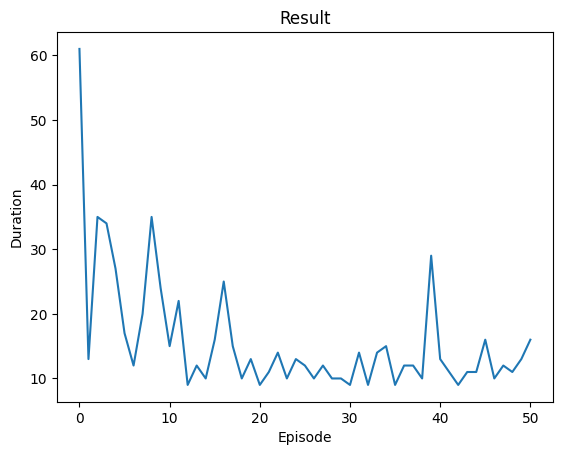

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()